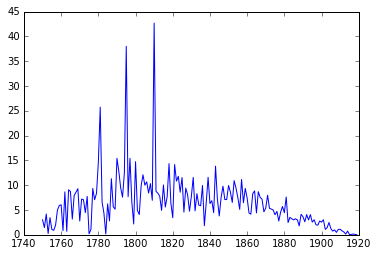

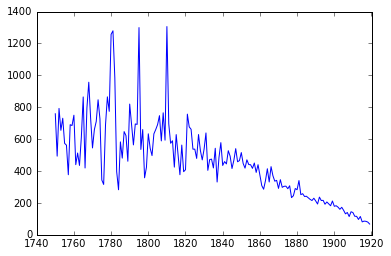

(0.73684003042324508, 2.2773582087975434e-30)


In [3]:
import math
import numpy as np

from scipy import stats

from hol.year_series import YearSeries
from hol.models import Count

import matplotlib.pyplot as plt
%matplotlib inline

years = range(1750, 1920)

topns = YearSeries(years, level1=1)

def print_series(token):
    
    # Log-likelihood
    logl = topns.rank_series(token)
    plt.plot(*zip(*logl.items()))
    plt.show()
    
    # WPM
    wpm = Count.token_wpm_series(token, years)
    plt.plot(*zip(*wpm.items()))
    plt.show()
    
    print(stats.pearsonr(list(logl.values()), list(wpm.values())))

# different:
# art
    
print_series('thy')